## Beginning

In [1]:
import pandas as pd
import numpy as np
import regex as re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from statistics import multimode
from apyori import apriori
import utils

classifiers = ["FTD", "GINCO", "CORE", "GINCO-X-GENRE", "FTD-X-GENRE", "CORE-X-GENRE", "X-GENRE"]

# Open the file

# Show all columns
pd.set_option('display.max_columns', None)

corpus_name = "MaCoCu-mk-shuffled"

corpus = pd.read_csv("MaCoCu-mk_with_predictions.csv",index_col=0, sep="\t")

# Define the extended corpus and domain-level corpus if you already created them
extended_corpus = pd.read_csv(f"MaCoCu-mk-shuffled_with_predictions-domain-info-added.csv", sep="\t", index_col = 0)
genre_distribution = pd.read_csv(f"MaCoCu-mk-shuffled-domain-level.csv", sep="\t", index_col = 0)

In [2]:
corpus.head(3)

,domain,url,text,doc,length,FTD,FTD_label_distribution,FTD_confidence,GINCO,GINCO_label_distribution,GINCO_confidence,CORE,CORE_label_distribution,CORE_confidence,GINCO-X-GENRE,GINCO-X-GENRE_label_distribution,GINCO-X-GENRE_confidence,FTD-X-GENRE,FTD-X-GENRE_label_distribution,FTD-X-GENRE_confidence,CORE-X-GENRE,CORE-X-GENRE_label_distribution,CORE-X-GENRE_confidence,X-GENRE,X-GENRE_label_distribution,X-GENRE_confidence,X-GENRE-majority-label,X-GENRE-majority-label-tie
0,gg.mk,https://gg.mk/,"Тоа е тоа, екипа. Претпоследната епизода ја на...","<doc id=""macocu.mk.4"" title=""GG.MK - е-спорт &...",864,A17 (review),"{7: 0.0152, 8: 0.1352, 0: 0.0334, 1: 0.0402, 6...",0.643622,List of Summaries/Excerpts,"{'Forum': 0.0036, 'News/Reporting': 0.0147, 'O...",0.919893,Opinion,"{'Interactive Discussion': 0.0085, 'Narrative'...",0.541413,Opinion/Argumentation,"{'Information/Explanation': 0.0055, 'Opinion/A...",0.861316,Promotion,"{'Promotion': 0.526, 'Opinion/Argumentation': ...",0.525988,Opinion/Argumentation,"{'Other': 0.0953, 'Information/Explanation': 0...",0.419943,Opinion/Argumentation,"{'Other': 0.0002, 'Information/Explanation': 0...",0.998700,Opinion/Argumentation,no
1,qs.mk,https://www.qs.mk/,"Парадата на гордоста се враќа под слоганот ""Во...","<doc id=""macocu.mk.5"" title=""КВИР СКВЕР Скопје...",1054,A12 (promotion),"{7: 0.0056, 8: 0.0162, 0: 0.0263, 1: 0.0047, 6...",0.904037,List of Summaries/Excerpts,"{'Forum': 0.0037, 'News/Reporting': 0.0111, 'O...",0.780482,Informational Description/Explanation,"{'Interactive Discussion': 0.001, 'Narrative':...",0.950632,Promotion,"{'Information/Explanation': 0.0014, 'Opinion/A...",0.990890,Promotion,"{'Promotion': 0.9479, 'Opinion/Argumentation':...",0.947886,News,"{'Other': 0.1212, 'Information/Explanation': 0...",0.533915,Promotion,"{'Other': 0.0004, 'Information/Explanation': 0...",0.998806,Promotion,no
2,in2.mk,http://in2.mk/,"Од крајот на месец Ноември 2009 година, своето...","<doc id=""macocu.mk.25"" title=""IN2 - ПOЧЕTHA CT...",162,A12 (promotion),"{7: 0.0102, 8: 0.0147, 0: 0.0178, 1: 0.0055, 6...",0.902866,Promotion,"{'Forum': 0.0014, 'News/Reporting': 0.0022, 'O...",0.957065,Informational Description/Explanation,"{'Interactive Discussion': 0.0011, 'Narrative'...",0.976693,Promotion,"{'Information/Explanation': 0.0014, 'Opinion/A...",0.989641,Promotion,"{'Promotion': 0.9251, 'Opinion/Argumentation':...",0.925099,Information/Explanation,"{'Other': 0.0706, 'Information/Explanation': 0...",0.317117,Promotion,"{'Other': 0.0003, 'Information/Explanation': 0...",0.998599,Promotion,no


In [3]:
# Keep only relevant columns
corpus = corpus[['domain', 'url', 'text', 'doc', 'length', 'FTD',
       'GINCO', 'CORE', 'GINCO-X-GENRE',
       'FTD-X-GENRE', 'CORE-X-GENRE','X-GENRE']]

In [4]:
corpus["FTD"].head()

0          A17 (review)
1       A12 (promotion)
2       A12 (promotion)
3    A1 (argumentative)
4    A1 (argumentative)
Name: FTD, dtype: object

In [6]:
corpus["FTD"].head()

0    A14 (academic)
1         A8 (news)
2         A8 (news)
3         A8 (news)
4      A17 (review)
Name: FTD, dtype: object

In [5]:
# Now, let's shuffle the predictions of all classifiers
for i in classifiers:
	label_list = list(corpus[i])
	random.shuffle(label_list)
	corpus[i] = label_list

corpus.head(5)


,domain,url,text,doc,length,FTD,GINCO,CORE,GINCO-X-GENRE,FTD-X-GENRE,CORE-X-GENRE,X-GENRE
0,gg.mk,https://gg.mk/,"Тоа е тоа, екипа. Претпоследната епизода ја на...","<doc id=""macocu.mk.4"" title=""GG.MK - е-спорт &...",864,A14 (academic),Opinion/Argumentation,Narrative,News,Promotion,Opinion/Argumentation,Opinion/Argumentation
1,qs.mk,https://www.qs.mk/,"Парадата на гордоста се враќа под слоганот ""Во...","<doc id=""macocu.mk.5"" title=""КВИР СКВЕР Скопје...",1054,A8 (news),Information/Explanation,Narrative,Information/Explanation,Promotion,News,Instruction
2,in2.mk,http://in2.mk/,"Од крајот на месец Ноември 2009 година, своето...","<doc id=""macocu.mk.25"" title=""IN2 - ПOЧЕTHA CT...",162,A8 (news),News/Reporting,Informational Description/Explanation,Information/Explanation,Promotion,Information/Explanation,Other
3,ldp.mk,https://ldp.mk/,Што не прави либрали?\nЕманципација од стравов...,"<doc id=""macocu.mk.35"" title=""Либерално демокр...",343,A8 (news),Information/Explanation,Informational Description/Explanation,Information/Explanation,Promotion,Information/Explanation,News
4,iep.mk,https://iep.mk/,ИНИЦИЈАТИВА ЗА ЕВРОПСКА ПЕРСПЕКТИВА\nЗдружение...,"<doc id=""macocu.mk.37"" title=""Иницијатива за Е...",182,A17 (review),News/Reporting,Narrative,Information/Explanation,Instruction,News,News


## General analysis

### Label confidence per classifier

In [ ]:
# Print the label confidence for each classifier
utils.label_confidence(corpus, classifiers)

### Most frequent values per classifier

In [ ]:
utils.most_frequent_values(corpus, classifiers)

### Label distribution per classifier

In [7]:
# Create a dataframe with label distribution per classifier
utils.label_distribution(corpus, classifiers)


| label_distribution_FTD       | label_distribution_GINCO             | label_distribution_CORE                         | label_distribution_GINCO-X-GENRE   | label_distribution_FTD-X-GENRE    | label_distribution_CORE-X-GENRE   | label_distribution_X-GENRE        |
|:-----------------------------|:-------------------------------------|:------------------------------------------------|:-----------------------------------|:----------------------------------|:----------------------------------|:----------------------------------|
| ('A12 (promotion)', 0.42)    | ('News/Reporting', 0.31)             | ('Informational Description/Explanation', 0.58) | ('News', 0.31)                     | ('Promotion', 0.44)               | ('Information/Explanation', 0.36) | ('News', 0.34)                    |
| ('A8 (news)', 0.2)           | ('Promotion', 0.24)                  | ('Narrative', 0.24)                             | ('Promotion', 0.29)                | ('News', 0.26)                    | ('Ne

## Analysis based on domains

### Create a domain level corpus and the extended corpus

In [8]:
# Create a corpus where instances are grouped into domains, and with additional information on the most common labels per domains
genre_distribution = utils.calculate_label_per_domain(corpus, classifiers)

genre_distribution.head(3)


,domain_id,genres-in-domain-FTD,genres-in-domain-GINCO,genres-in-domain-CORE,genres-in-domain-GINCO-X-GENRE,genres-in-domain-FTD-X-GENRE,genres-in-domain-CORE-X-GENRE,genres-in-domain-X-GENRE,biggest-label-frequency-FTD,biggest-label-frequency-GINCO,biggest-label-frequency-CORE,biggest-label-frequency-GINCO-X-GENRE,biggest-label-frequency-FTD-X-GENRE,biggest-label-frequency-CORE-X-GENRE,biggest-label-frequency-X-GENRE,most_frequent_label_FTD,tie-FTD,most_frequent_label_GINCO,tie-GINCO,most_frequent_label_CORE,tie-CORE,most_frequent_label_GINCO-X-GENRE,tie-GINCO-X-GENRE,most_frequent_label_FTD-X-GENRE,tie-FTD-X-GENRE,most_frequent_label_CORE-X-GENRE,tie-CORE-X-GENRE,most_frequent_label_X-GENRE,tie-X-GENRE
0,101foot.mk,"{'A9 (legal)': 1, 'A16 (information)': 3, 'A12...","{'Information/Explanation': 3, 'News/Reporting...","{'Informational Description/Explanation': 9, '...","{'Promotion': 1, 'Opinion/Argumentation': 1, '...","{'Promotion': 4, 'News': 4, 'Legal': 1, 'Instr...","{'News': 4, 'Forum': 1, 'Information/Explanati...","{'Opinion/Argumentation': 1, 'Instruction': 2,...",3,6,9,4,4,4,5,A16 (information),yes,News/Reporting,no,Informational Description/Explanation,no,Information/Explanation,no,Promotion,yes,News,no,News,no
1,2020.iffs.mk,"{'A16 (information)': 1, 'A12 (promotion)': 7,...","{'Information/Explanation': 1, 'Instruction': ...","{'Informational Description/Explanation': 6, '...","{'Opinion/Argumentation': 2, 'Promotion': 3, '...","{'News': 5, 'Promotion': 5}","{'News': 4, 'Other': 1, 'Information/Explanati...","{'Information/Explanation': 6, 'News': 3, 'Opi...",7,3,6,3,5,4,6,A12 (promotion),no,News/Reporting,no,Informational Description/Explanation,no,News,yes,News,yes,Information/Explanation,yes,Information/Explanation,no
2,24apteka.mk,"{'A12 (promotion)': 3, 'A8 (news)': 2, 'A16 (i...","{'News/Reporting': 5, 'Promotion': 4, 'Instruc...","{'Informational Description/Explanation': 7, '...","{'Promotion': 5, 'News': 5}","{'News': 3, 'Promotion': 1, 'Information/Expla...","{'News': 3, 'Information/Explanation': 5, 'Opi...","{'News': 5, 'Promotion': 3, 'Instruction': 1, ...",3,5,7,5,5,5,5,A12 (promotion),no,News/Reporting,no,Informational Description/Explanation,no,Promotion,yes,Information/Explanation,no,Information/Explanation,no,News,no


In [9]:
# Save the domain-level corpus
genre_distribution.to_csv(f"{corpus_name}-domain-level.csv", sep="\t")

In [10]:
# Then merge the domain-level df with the initial corpus so that all the domain information will be added to each instance from the domain
extended_corpus = pd.merge(left = corpus, right = genre_distribution, how = "left", left_on= "domain", right_on= "domain_id", suffixes=["",""])

extended_corpus.head(2)

,domain,url,text,doc,length,FTD,GINCO,CORE,GINCO-X-GENRE,FTD-X-GENRE,CORE-X-GENRE,X-GENRE,domain_id,genres-in-domain-FTD,genres-in-domain-GINCO,genres-in-domain-CORE,genres-in-domain-GINCO-X-GENRE,genres-in-domain-FTD-X-GENRE,genres-in-domain-CORE-X-GENRE,genres-in-domain-X-GENRE,biggest-label-frequency-FTD,biggest-label-frequency-GINCO,biggest-label-frequency-CORE,biggest-label-frequency-GINCO-X-GENRE,biggest-label-frequency-FTD-X-GENRE,biggest-label-frequency-CORE-X-GENRE,biggest-label-frequency-X-GENRE,most_frequent_label_FTD,tie-FTD,most_frequent_label_GINCO,tie-GINCO,most_frequent_label_CORE,tie-CORE,most_frequent_label_GINCO-X-GENRE,tie-GINCO-X-GENRE,most_frequent_label_FTD-X-GENRE,tie-FTD-X-GENRE,most_frequent_label_CORE-X-GENRE,tie-CORE-X-GENRE,most_frequent_label_X-GENRE,tie-X-GENRE
0,gg.mk,https://gg.mk/,"Тоа е тоа, екипа. Претпоследната епизода ја на...","<doc id=""macocu.mk.4"" title=""GG.MK - е-спорт &...",864,A14 (academic),Opinion/Argumentation,Narrative,News,Promotion,Opinion/Argumentation,Opinion/Argumentation,gg.mk,"{'A14 (academic)': 1, 'A1 (argumentative)': 3,...","{'Opinion/Argumentation': 2, 'Promotion': 1, '...","{'Narrative': 1, 'Informational Description/Ex...","{'News': 4, 'Information/Explanation': 4, 'Oth...","{'Promotion': 4, 'Information/Explanation': 2,...","{'Opinion/Argumentation': 1, 'News': 3, 'Forum...","{'Opinion/Argumentation': 2, 'Promotion': 2, '...",3,4,8,4,4,4,3,A1 (argumentative),yes,News/Reporting,no,Informational Description/Explanation,no,Information/Explanation,yes,Promotion,no,Information/Explanation,no,News,no
1,qs.mk,https://www.qs.mk/,"Парадата на гордоста се враќа под слоганот ""Во...","<doc id=""macocu.mk.5"" title=""КВИР СКВЕР Скопје...",1054,A8 (news),Information/Explanation,Narrative,Information/Explanation,Promotion,News,Instruction,qs.mk,"{'A8 (news)': 1, 'A12 (promotion)': 4, 'A1 (ar...","{'Information/Explanation': 3, 'News/Reporting...","{'Narrative': 4, 'Opinion': 1, 'Informational ...","{'Information/Explanation': 2, 'News': 2, 'Pro...","{'Promotion': 5, 'News': 3, 'Information/Expla...","{'News': 4, 'Information/Explanation': 4, 'For...","{'Instruction': 2, 'Promotion': 2, 'Informatio...",4,6,5,4,5,4,3,A12 (promotion),no,News/Reporting,no,Informational Description/Explanation,no,Promotion,no,Promotion,no,News,yes,Information/Explanation,yes


In [11]:
# Save the extended corpus
extended_corpus.to_csv(f"{corpus_name}_with_predictions-domain-info-added.csv", sep="\t")

### Graphs based on frequency of most frequent label in the domains

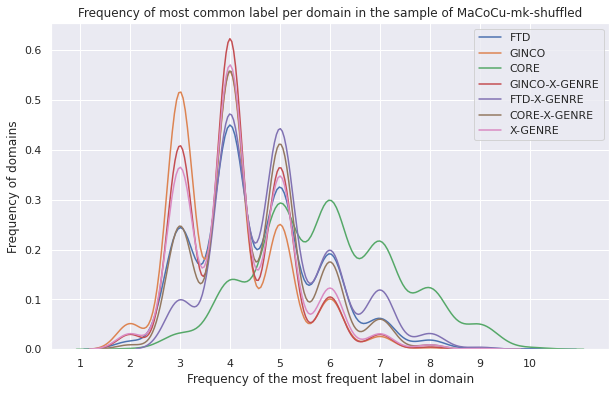

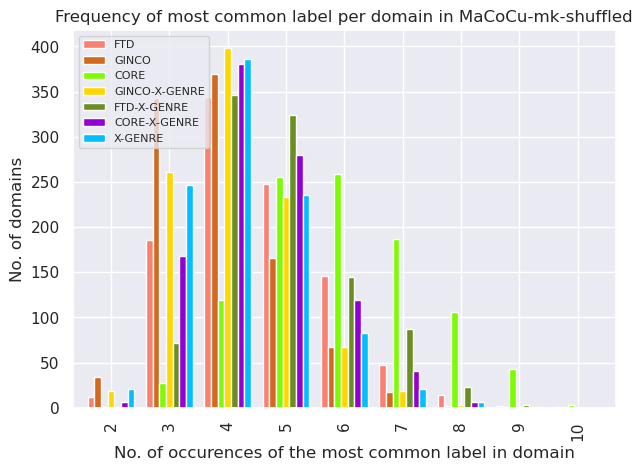

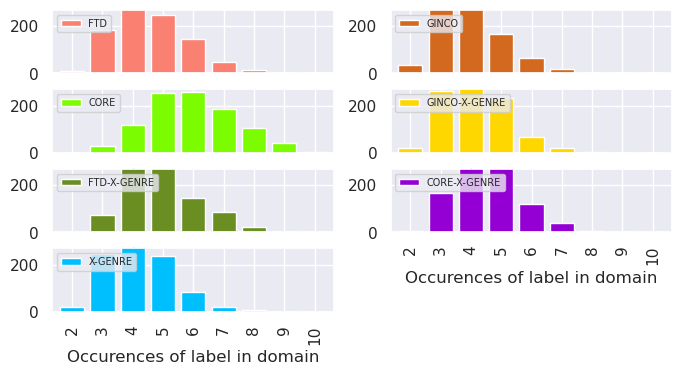

In [12]:
utils.create_graphs(genre_distribution, classifiers, corpus_name)

### Most frequent labels per domain
We will look into how many times each specific category was most frequent on a domain. For this, I will use the domain-level corpus (genre_distribution dataframe). I will group the texts into domains and calculate for each label in each schema in how many domains it is the most frequent.

In [13]:
utils.label_distribution_per_domain(genre_distribution, classifiers)

| label_distribution_FTD       | label_distribution_GINCO             | label_distribution_CORE                         | label_distribution_GINCO-X-GENRE   | label_distribution_FTD-X-GENRE    | label_distribution_CORE-X-GENRE   | label_distribution_X-GENRE        |
|:-----------------------------|:-------------------------------------|:------------------------------------------------|:-----------------------------------|:----------------------------------|:----------------------------------|:----------------------------------|
| ('A12 (promotion)', 0.73)    | ('News/Reporting', 0.51)             | ('Informational Description/Explanation', 0.88) | ('Promotion', 0.41)                | ('Promotion', 0.67)               | ('Information/Explanation', 0.52) | ('News', 0.54)                    |
| ('A8 (news)', 0.15)          | ('Promotion', 0.29)                  | ('Narrative', 0.11)                             | ('News', 0.4)                      | ('News', 0.21)                    | ('Ne

### Calculating scores assuming domains are uni-genre
Calculating F1, precision, recall assuming that domains are uni-genre. To calculate this, I will take the predicted labels as y_pred and the most_frequent_label (most frequent label in domain) labels as y_true.

For this, I will use the extended corpus (which is instance-level, but contains the information on domains).

Classifier: FTD
Macro F1: 0.15, Micro F1: 0.45, Accuracy: 0.45
Krippendorfs Alpha: 0.12


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                    precision    recall  f1-score   support

    A14 (academic)       0.00      0.00      0.00         0
         A8 (news)       0.29      0.38      0.33      1500
      A17 (review)       0.02      0.27      0.04        30
A1 (argumentative)       0.16      0.36      0.22       610
 A16 (information)       0.13      0.36      0.20       450
   A12 (promotion)       0.84      0.49      0.62      7350
    A11 (personal)       0.00      0.00      0.00         0
  A7 (instruction)       0.02      0.28      0.05        40
      A4 (fiction)       0.00      0.00      0.00         0
        A9 (legal)       0.02      0.20      0.04        20

          accuracy                           0.45     10000
         macro avg       0.15      0.23      0.15     10000
      weighted avg       0.68      0.45      0.53     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


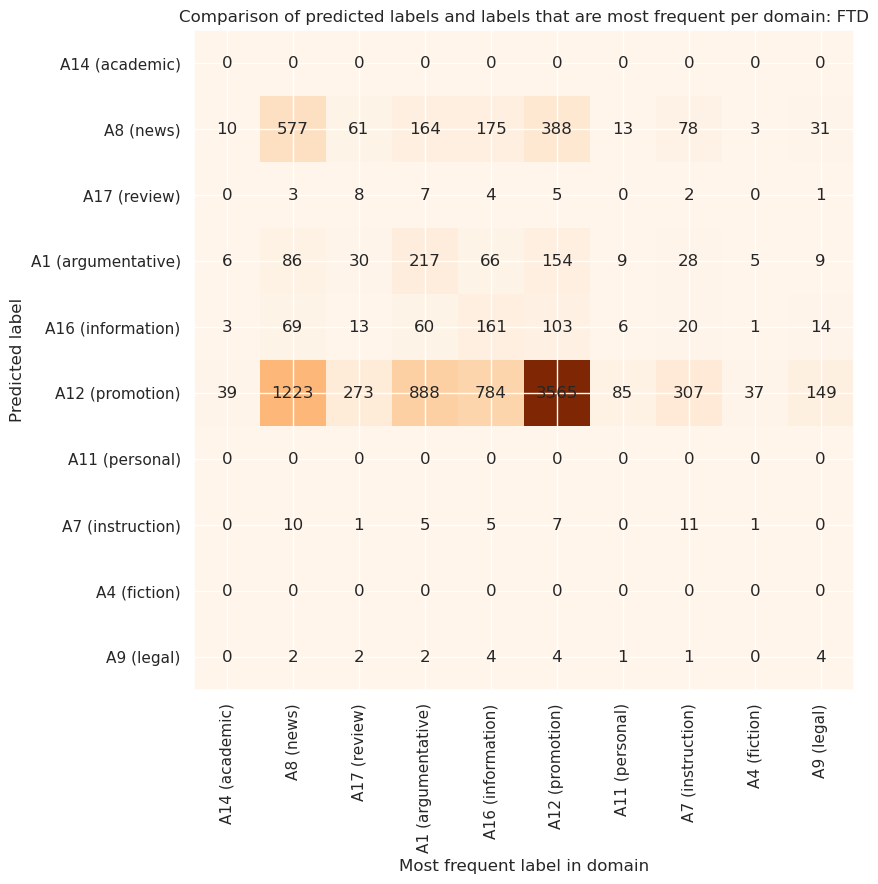

Classifier: GINCO
Macro F1: 0.2, Micro F1: 0.4, Accuracy: 0.4
Krippendorfs Alpha: 0.17
                            precision    recall  f1-score   support

     Opinion/Argumentation       0.10      0.30      0.15       260
   Information/Explanation       0.29      0.35      0.32      1450
            News/Reporting       0.68      0.42      0.52      5060
List of Summaries/Excerpts       0.09      0.33      0.14       220
                     Other       0.04      0.33      0.07        40
                 Promotion       0.46      0.39      0.42      2870
               Instruction       0.04      0.26      0.07        80
                     Forum       0.02      0.20      0.03        10
          Legal/Regulation       0.03      0.20      0.05        10

                  accuracy                           0.40     10000
                 macro avg       0.19      0.31      0.20     10000
              weighted avg       0.52      0.40      0.44     10000



<Figure size 700x500 with 0 Axes>

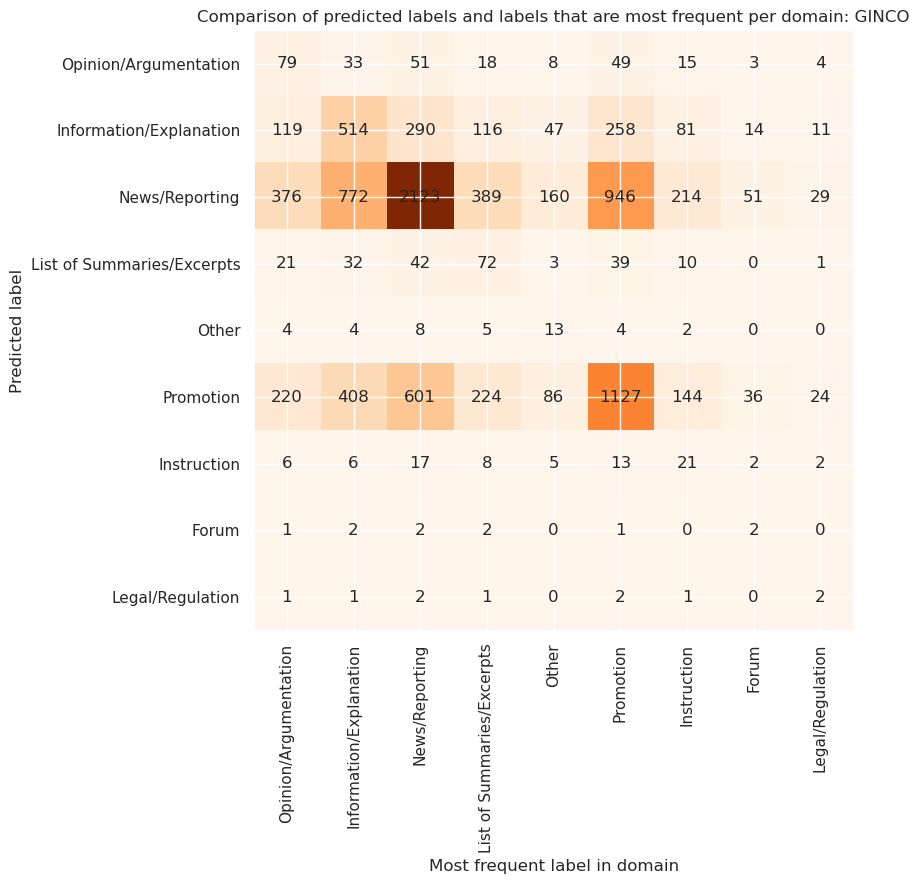

Classifier: CORE
Macro F1: 0.14, Micro F1: 0.6, Accuracy: 0.6
Krippendorfs Alpha: 0.07


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                       precision    recall  f1-score   support

                            Narrative       0.22      0.47      0.30      1130
Informational Description/Explanation       0.93      0.62      0.74      8790
                              Opinion       0.02      0.27      0.03        30
                 How-To/Instructional       0.01      0.30      0.03        20
             Informational Persuasion       0.02      0.40      0.03        30
                               Spoken       0.00      0.00      0.00         0
               Interactive Discussion       0.00      0.00      0.00         0
                              Lyrical       0.00      0.00      0.00         0

                             accuracy                           0.60     10000
                            macro avg       0.15      0.26      0.14     10000
                         weighted avg       0.84      0.60      0.69     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 700x500 with 0 Axes>

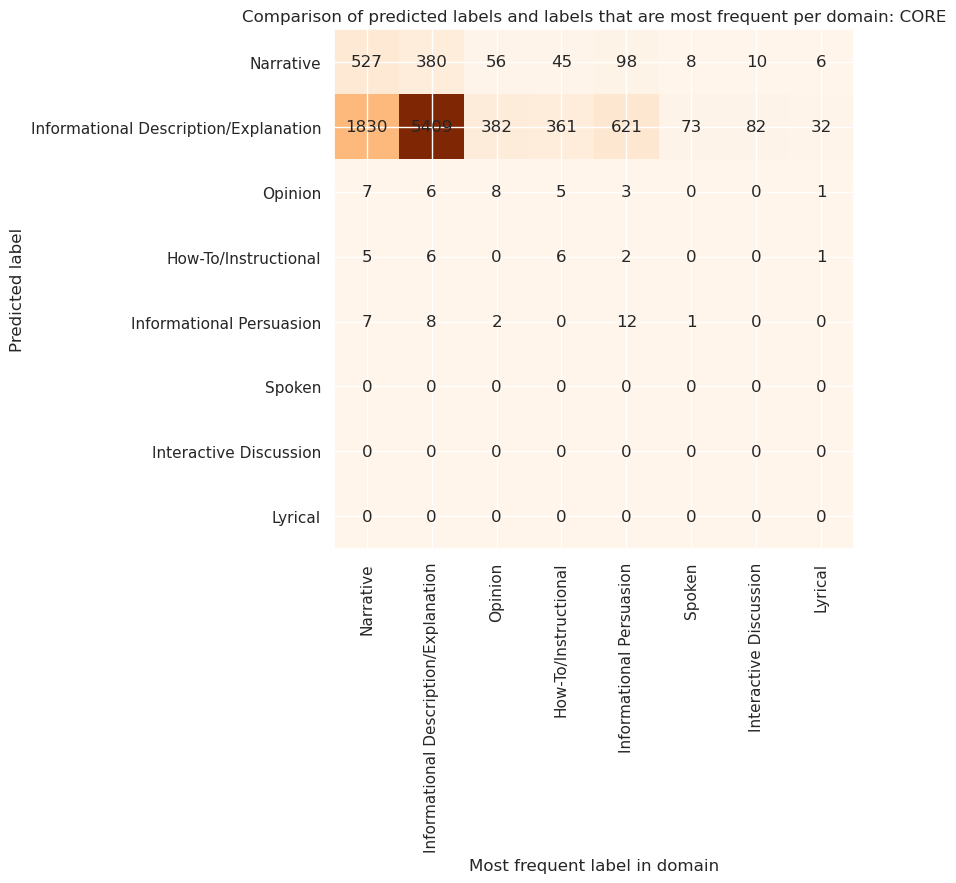

Classifier: GINCO-X-GENRE
Macro F1: 0.18, Micro F1: 0.41, Accuracy: 0.41
Krippendorfs Alpha: 0.19


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

                   News       0.57      0.43      0.49      4040
Information/Explanation       0.31      0.38      0.34      1490
              Promotion       0.59      0.42      0.49      4070
  Opinion/Argumentation       0.06      0.28      0.09       130
                  Other       0.07      0.31      0.11       170
            Instruction       0.05      0.28      0.08       100
                  Forum       0.00      0.00      0.00         0
                  Legal       0.00      0.00      0.00         0
          Prose/Lyrical       0.00      0.00      0.00         0

               accuracy                           0.41     10000
              macro avg       0.18      0.23      0.18     10000
           weighted avg       0.52      0.41      0.45     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 700x500 with 0 Axes>

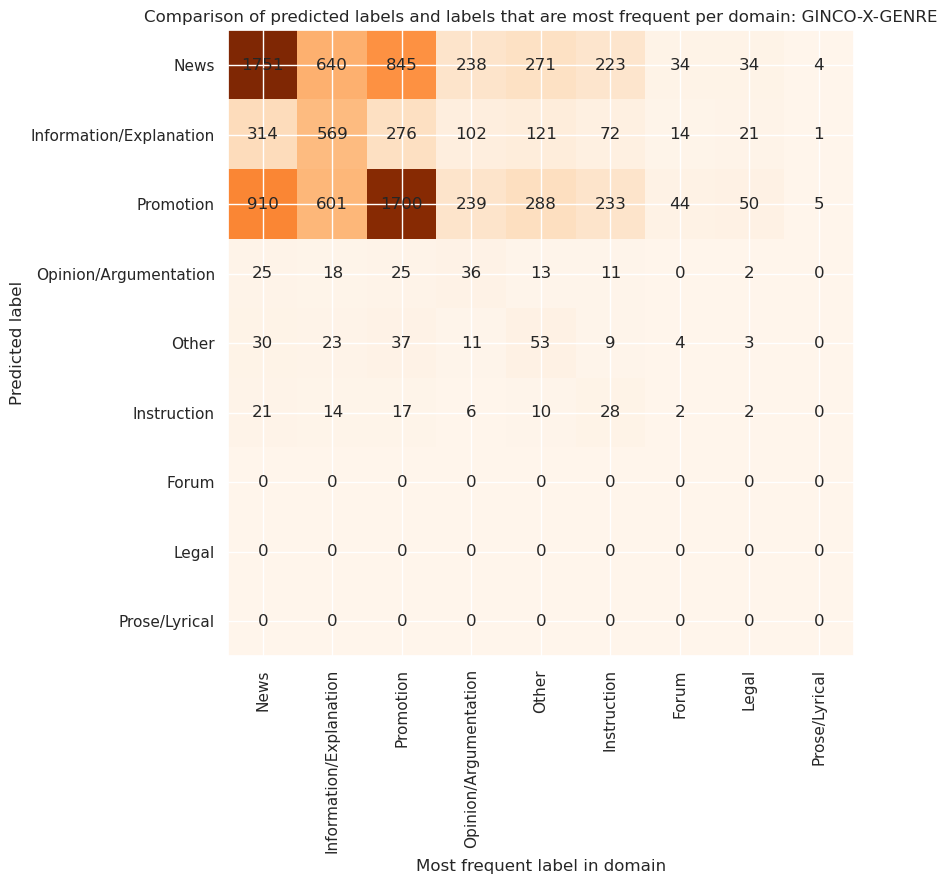

Classifier: FTD-X-GENRE
Macro F1: 0.2, Micro F1: 0.49, Accuracy: 0.49
Krippendorfs Alpha: 0.17


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

              Promotion       0.80      0.52      0.63      6700
            Instruction       0.03      0.33      0.05        40
Information/Explanation       0.25      0.42      0.31      1150
                   News       0.35      0.44      0.39      2110
          Prose/Lyrical       0.00      0.00      0.00         0
                  Legal       0.00      0.00      0.00         0
  Opinion/Argumentation       0.00      0.00      0.00         0

               accuracy                           0.49     10000
              macro avg       0.20      0.24      0.20     10000
           weighted avg       0.64      0.49      0.54     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 700x500 with 0 Axes>

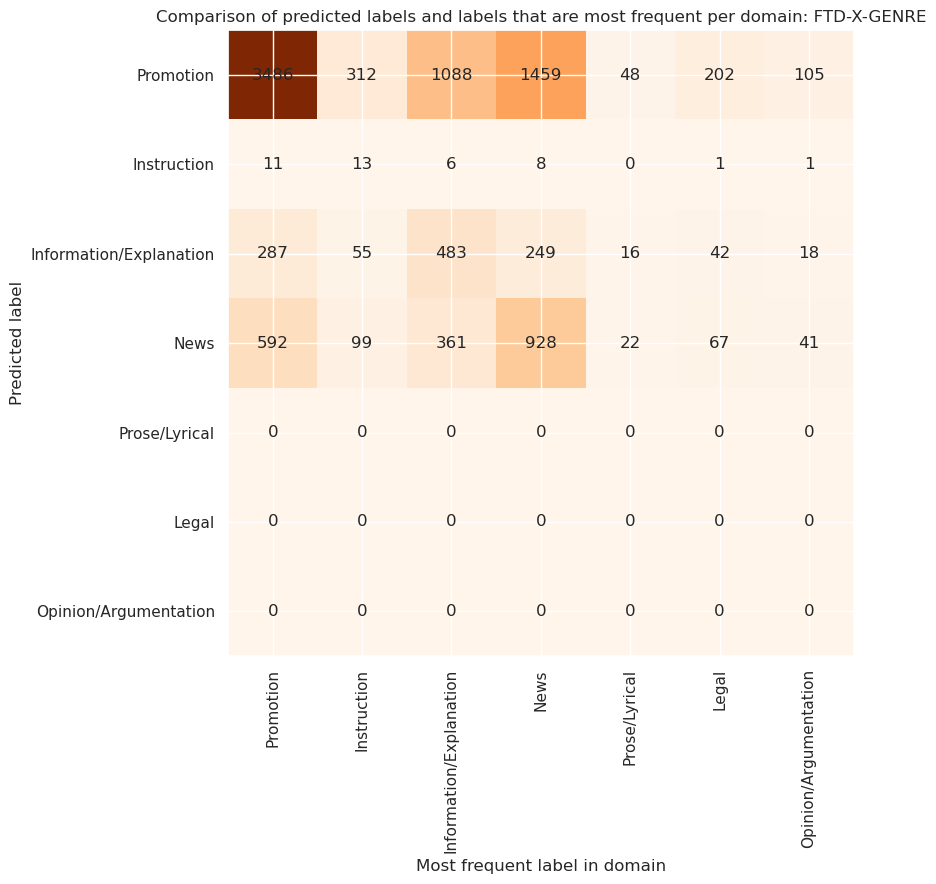

Classifier: CORE-X-GENRE
Macro F1: 0.21, Micro F1: 0.45, Accuracy: 0.45
Krippendorfs Alpha: 0.18


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

  Opinion/Argumentation       0.13      0.36      0.19       450
                   News       0.56      0.45      0.50      3890
Information/Explanation       0.66      0.46      0.55      5150
            Instruction       0.14      0.37      0.20       490
                  Forum       0.01      0.40      0.02        10
          Prose/Lyrical       0.02      0.30      0.04        10
                  Other       0.00      0.00      0.00         0

               accuracy                           0.45     10000
              macro avg       0.22      0.33      0.21     10000
           weighted avg       0.57      0.45      0.49     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 700x500 with 0 Axes>

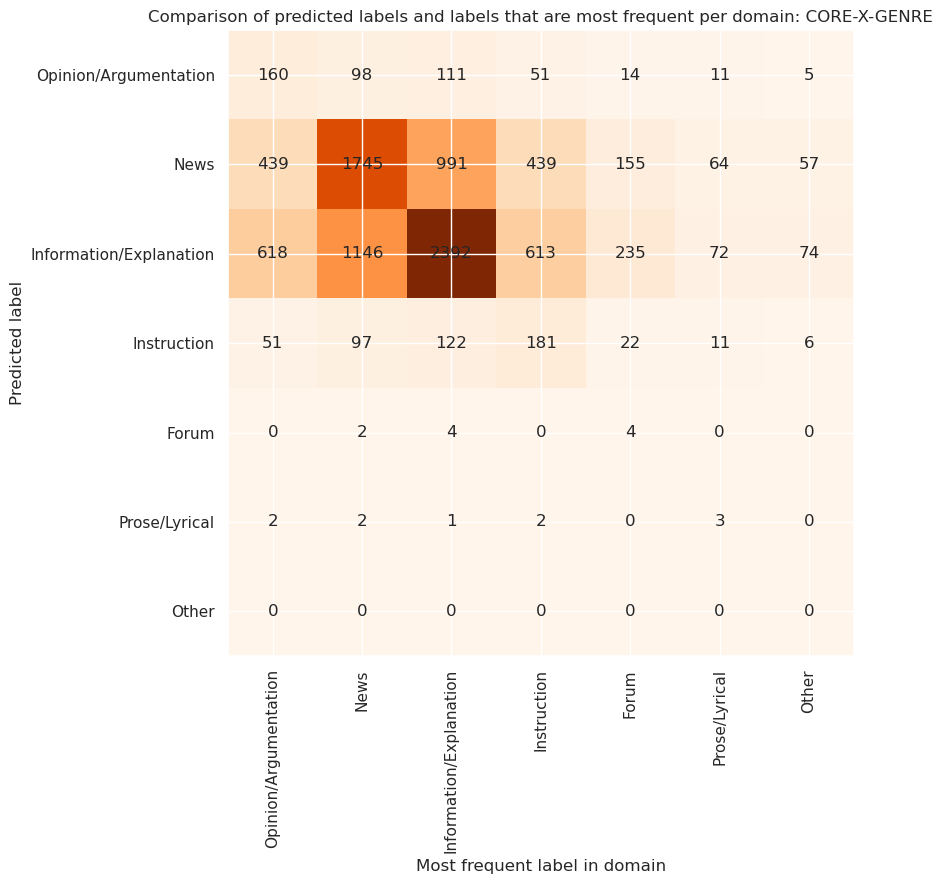

Classifier: X-GENRE
Macro F1: 0.17, Micro F1: 0.42, Accuracy: 0.42
Krippendorfs Alpha: 0.17


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

  Opinion/Argumentation       0.06      0.32      0.10       140
            Instruction       0.06      0.31      0.10       120
                  Other       0.01      0.20      0.01        10
                   News       0.69      0.44      0.54      5350
              Promotion       0.47      0.41      0.44      3040
Information/Explanation       0.28      0.37      0.32      1330
                  Legal       0.01      0.30      0.02        10
                  Forum       0.00      0.00      0.00         0
          Prose/Lyrical       0.00      0.00      0.00         0

               accuracy                           0.42     10000
              macro avg       0.17      0.26      0.17     10000
           weighted avg       0.55      0.42      0.47     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 700x500 with 0 Axes>

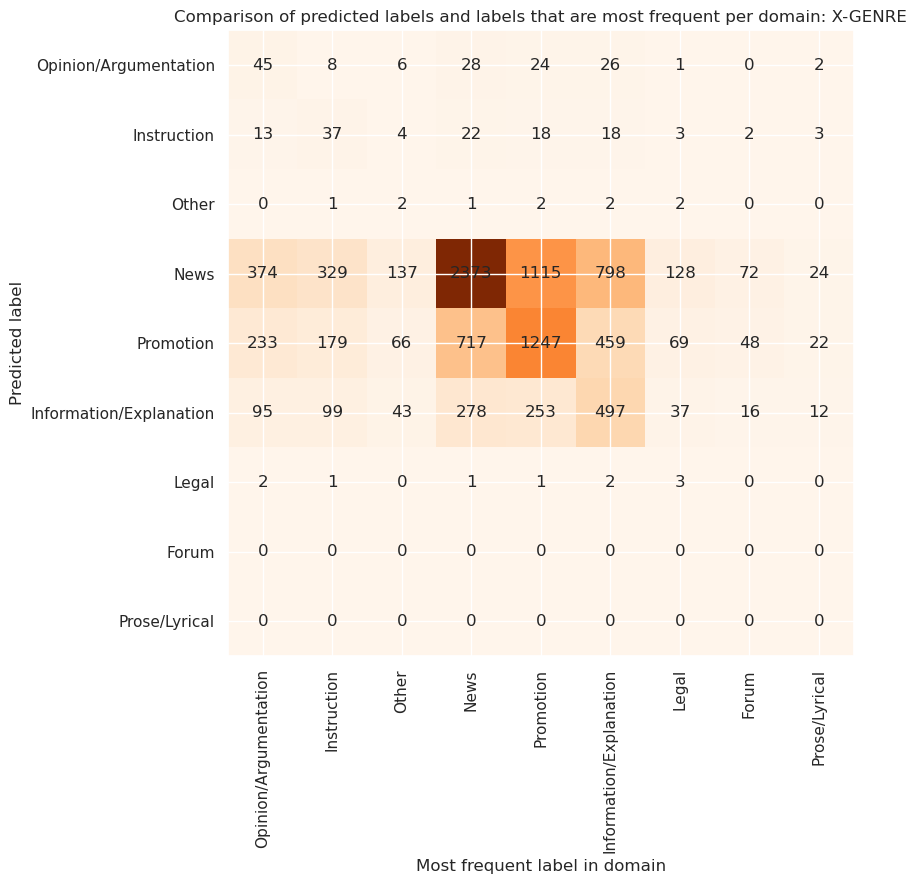

| Classifier    |   Accuracy |   Krippendorfs Alpha |   Macro F1 |   Micro F1 |   Macro precision |   Macro recall |
|:--------------|-----------:|---------------------:|-----------:|-----------:|------------------:|---------------:|
| CORE-X-GENRE  |       0.45 |                 0.18 |       0.21 |       0.45 |              0.22 |           0.33 |
| GINCO         |       0.4  |                 0.17 |       0.2  |       0.4  |              0.19 |           0.31 |
| FTD-X-GENRE   |       0.49 |                 0.17 |       0.2  |       0.49 |              0.2  |           0.24 |
| GINCO-X-GENRE |       0.41 |                 0.19 |       0.18 |       0.41 |              0.18 |           0.23 |
| X-GENRE       |       0.42 |                 0.17 |       0.17 |       0.42 |              0.17 |           0.26 |
| FTD           |       0.45 |                 0.12 |       0.15 |       0.45 |              0.15 |           0.23 |
| CORE          |       0.6  |                 0.07 |       0.14

<Figure size 700x500 with 0 Axes>

In [14]:
results_scores_based_on_domain = utils.scores_based_on_domains(extended_corpus, classifiers)

### Scores based on agreement of labels inside domains

In [2]:
utils.calculate_hits(extended_corpus, genre_distribution, classifiers)

| Classifier    |   Hits |   Hits percentage |
|:--------------|-------:|------------------:|
| CORE          |  18274 |              0.41 |
| CORE-X-GENRE  |  11794 |              0.26 |
| FTD           |  11380 |              0.25 |
| FTD-X-GENRE   |  13679 |              0.3  |
| GINCO         |   9246 |              0.21 |
| GINCO-X-GENRE |  10109 |              0.22 |
| X-GENRE       |  10358 |              0.23 |


## Comparison of X-GENRE predictions based on the majority prediction
Focus only on X-genre and assume the domain label to be the one that has been chosen most by ALL classifiers, calculate F1, (microF1, macroF1). For this, we will use the extended corpus.

Number of ties when defining the majority label:
|     |   X-GENRE-majority-label-tie |
|:----|-----------------------------:|
| no  |                       0.6947 |
| yes |                       0.3053 |
Majority label distribution:
|                         |   X-GENRE-majority-label |
|:------------------------|-------------------------:|
| Promotion               |                   0.4862 |
| Information/Explanation |                   0.2257 |
| News                    |                   0.0986 |
| Instruction             |                   0.0779 |
| Opinion/Argumentation   |                   0.0713 |
| Forum                   |                   0.0153 |
| Other                   |                   0.0145 |
| Legal                   |                   0.0073 |
| Prose/Lyrical           |                   0.0032 |
Classifier: GINCO-X-GENRE
Macro F1: 0.33, Micro F1: 0.54, Accuracy: 0.54
                         precision    recall  f1-score   support

Information/Explanatio

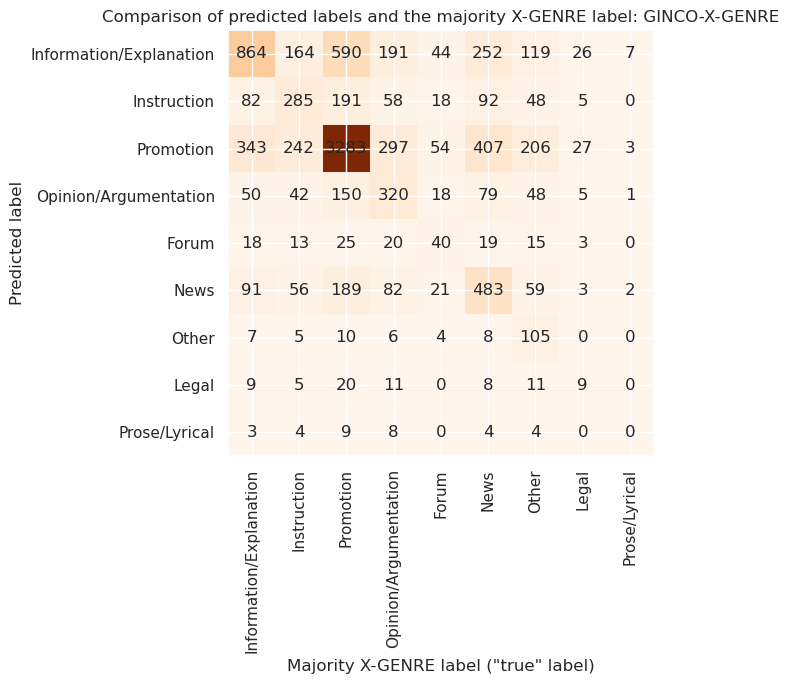

Classifier: FTD-X-GENRE
Macro F1: 0.38, Micro F1: 0.59, Accuracy: 0.58
                         precision    recall  f1-score   support

              Promotion       0.64      0.83      0.73      4862
Information/Explanation       0.58      0.44      0.50      2257
            Instruction       0.38      0.29      0.33       779
                   News       0.40      0.32      0.36       986
  Opinion/Argumentation       0.43      0.19      0.27       713
          Prose/Lyrical       0.17      0.44      0.24        32
                  Legal       0.18      0.56      0.27        73

              micro avg       0.58      0.59      0.59      9702
              macro avg       0.40      0.44      0.38      9702
           weighted avg       0.56      0.59      0.56      9702



<Figure size 700x500 with 0 Axes>

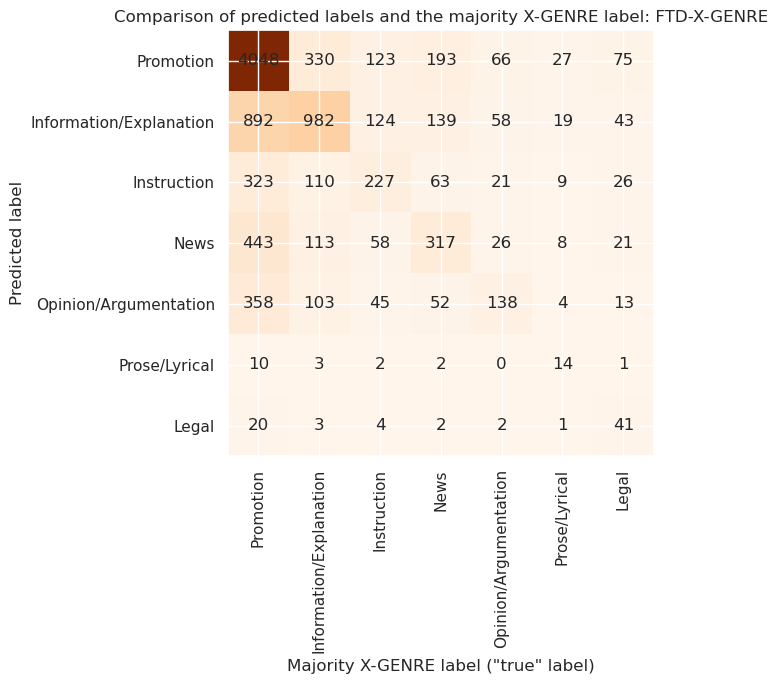

Classifier: CORE-X-GENRE
Macro F1: 0.29, Micro F1: 0.4, Accuracy: 0.3
                         precision    recall  f1-score   support

Information/Explanation       0.39      0.71      0.51      2257
  Opinion/Argumentation       0.26      0.52      0.35       713
                   News       0.30      0.41      0.35       986
          Prose/Lyrical       0.05      0.38      0.09        32
            Instruction       0.24      0.62      0.35       779
                  Forum       0.14      0.64      0.23       153
                  Other       0.13      0.16      0.14       145

              micro avg       0.30      0.59      0.40      5065
              macro avg       0.22      0.49      0.29      5065
           weighted avg       0.32      0.59      0.41      5065



<Figure size 700x500 with 0 Axes>

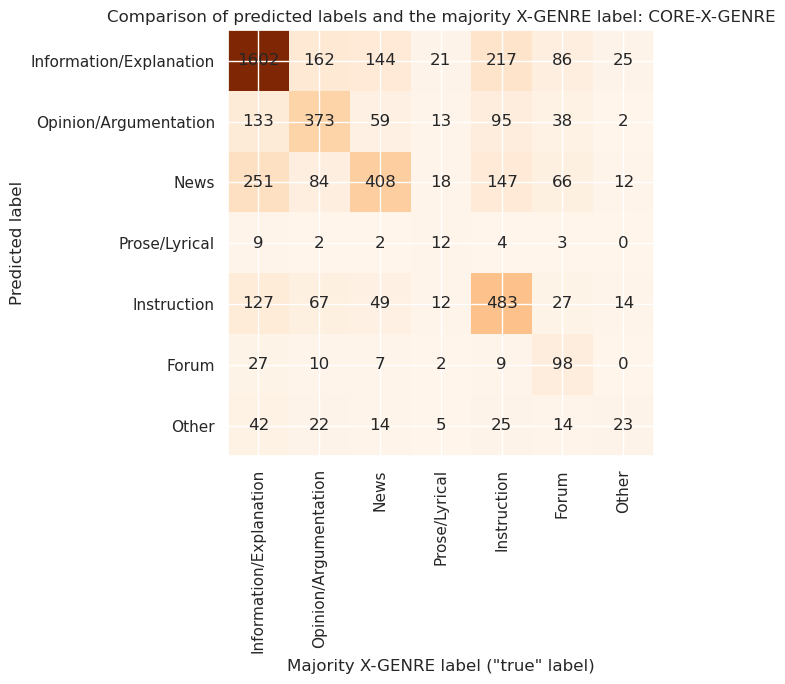

Classifier: X-GENRE
Macro F1: 0.36, Micro F1: 0.53, Accuracy: 0.53
                         precision    recall  f1-score   support

              Promotion       0.76      0.60      0.67      4862
  Opinion/Argumentation       0.30      0.50      0.38       713
                  Other       0.17      0.38      0.23       145
                   News       0.35      0.52      0.41       986
Information/Explanation       0.56      0.45      0.50      2257
            Instruction       0.35      0.39      0.37       779
                  Legal       0.18      0.41      0.25        73
                  Forum       0.19      0.31      0.24       153
          Prose/Lyrical       0.16      0.28      0.20        32

               accuracy                           0.53     10000
              macro avg       0.33      0.43      0.36     10000
           weighted avg       0.58      0.53      0.54     10000



<Figure size 700x500 with 0 Axes>

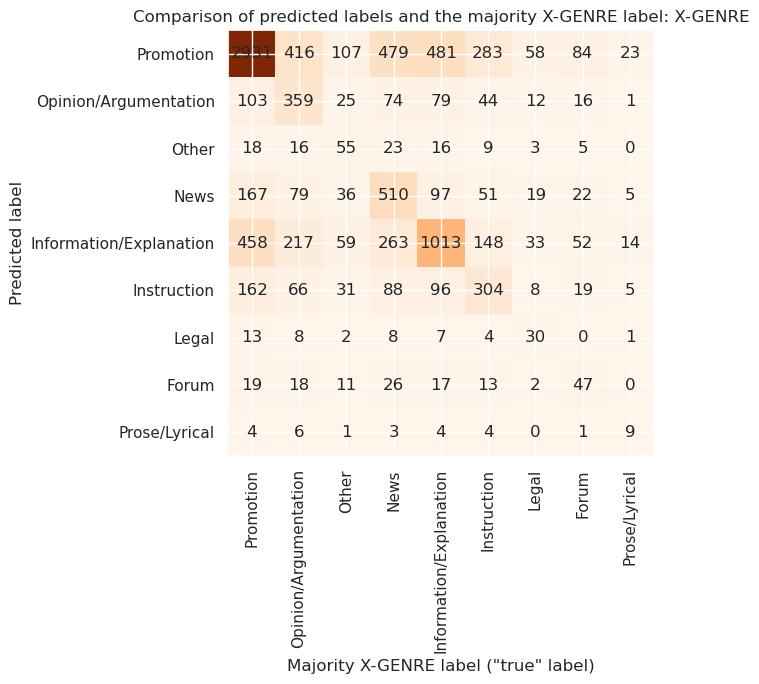

| Classifier    |   Accuracy |   Macro F1 |   Micro F1 |   Macro precision |   Macro recall |
|:--------------|-----------:|-----------:|-----------:|------------------:|---------------:|
| FTD-X-GENRE   |       0.58 |       0.38 |       0.59 |              0.4  |           0.44 |
| X-GENRE       |       0.53 |       0.36 |       0.53 |              0.33 |           0.43 |
| GINCO-X-GENRE |       0.54 |       0.33 |       0.54 |              0.32 |           0.39 |
| CORE-X-GENRE  |       0.3  |       0.29 |       0.4  |              0.22 |           0.49 |


<Figure size 700x500 with 0 Axes>

In [24]:
x_genre_majority_results = utils.scores_based_on_xgenre_majority(extended_corpus, "MaCoCu-is")

## Agreement between X-GENRE classifiers
For X-genre classifiers, calculate agreement between them via F1, macroF1, microF1 (one classifier y_pred, another y_true - confusion matrix).

Comparison of classifiers: GINCO-X-GENRE as y_true, FTD-X-GENRE as y_pred
Macro F1: 0.13, Micro F1: 0.33
                         precision    recall  f1-score   support

              Promotion       0.44      0.61      0.51      4467
Information/Explanation       0.14      0.17      0.15      1467
            Instruction       0.08      0.06      0.07       816
                   News       0.14      0.08      0.10      1352
  Opinion/Argumentation       0.09      0.03      0.04       993
          Prose/Lyrical       0.00      0.00      0.00        13
                  Legal       0.01      0.03      0.01        78

              micro avg       0.32      0.35      0.33      9186
              macro avg       0.13      0.14      0.13      9186
           weighted avg       0.27      0.35      0.30      9186



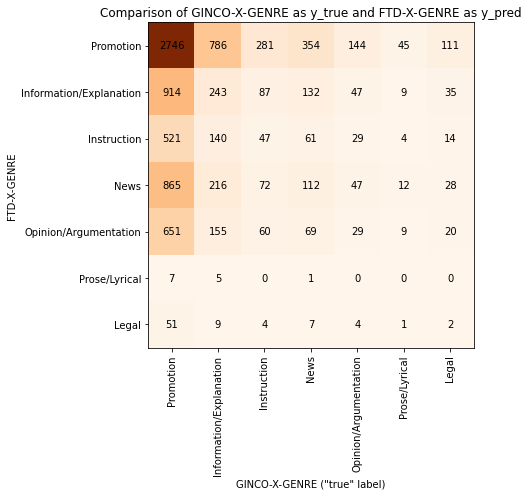

Comparison of classifiers: GINCO-X-GENRE as y_true, CORE-X-GENRE as y_pred
Macro F1: 0.1, Micro F1: 0.15
                         precision    recall  f1-score   support

Information/Explanation       0.15      0.41      0.22      1467
  Opinion/Argumentation       0.11      0.15      0.13       993
                   News       0.14      0.13      0.14      1352
          Prose/Lyrical       0.00      0.00      0.00        13
            Instruction       0.09      0.22      0.13       816
                  Forum       0.03      0.09      0.04       199
                  Other       0.07      0.02      0.03       615

              micro avg       0.12      0.21      0.15      5455
              macro avg       0.08      0.15      0.10      5455
           weighted avg       0.12      0.21      0.14      5455



<Figure size 432x288 with 0 Axes>

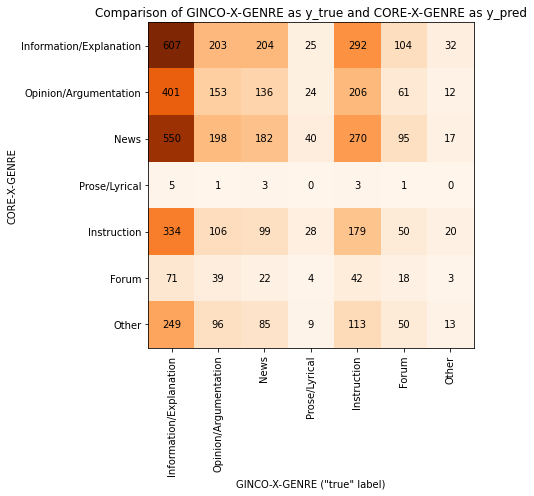

Comparison of classifiers: GINCO-X-GENRE as y_true, X-GENRE as y_pred
Macro F1: 0.11, Micro F1: 0.24
                         precision    recall  f1-score   support

              Promotion       0.44      0.38      0.41      4467
  Opinion/Argumentation       0.10      0.12      0.11       993
                  Other       0.07      0.04      0.05       615
                   News       0.14      0.15      0.14      1352
Information/Explanation       0.15      0.18      0.16      1467
            Instruction       0.08      0.09      0.08       816
                  Legal       0.01      0.01      0.01        78
                  Forum       0.02      0.03      0.03       199
          Prose/Lyrical       0.00      0.00      0.00        13

               accuracy                           0.24     10000
              macro avg       0.11      0.11      0.11     10000
           weighted avg       0.26      0.24      0.25     10000



<Figure size 432x288 with 0 Axes>

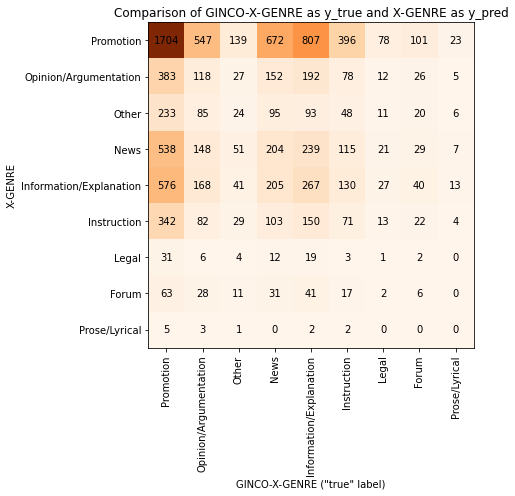

Comparison of classifiers: FTD-X-GENRE as y_true, GINCO-X-GENRE as y_pred
Macro F1: 0.13, Micro F1: 0.33
                         precision    recall  f1-score   support

              Promotion       0.61      0.44      0.51      6282
Information/Explanation       0.17      0.14      0.15      1693
            Instruction       0.06      0.08      0.07       605
                   News       0.08      0.14      0.10       789
  Opinion/Argumentation       0.03      0.09      0.04       320
          Prose/Lyrical       0.00      0.00      0.00        84
                  Legal       0.03      0.01      0.01       227

              micro avg       0.35      0.32      0.33     10000
              macro avg       0.14      0.13      0.13     10000
           weighted avg       0.43      0.32      0.36     10000



<Figure size 432x288 with 0 Axes>

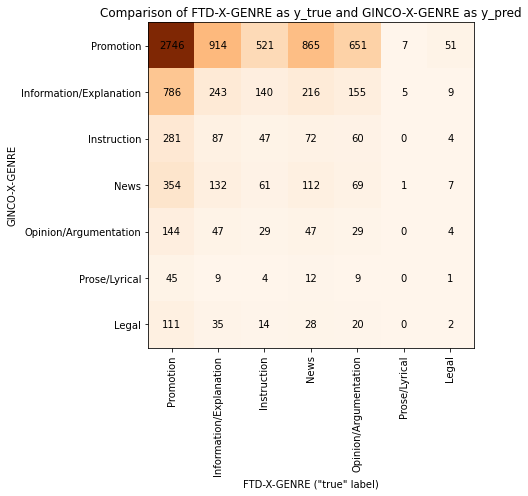

Comparison of classifiers: FTD-X-GENRE as y_true, CORE-X-GENRE as y_pred
Macro F1: 0.07, Micro F1: 0.1


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.

                         precision    recall  f1-score   support

              Promotion       0.00      0.00      0.00      6282
Information/Explanation       0.17      0.41      0.24      1693
            Instruction       0.06      0.20      0.09       605
                   News       0.07      0.12      0.09       789
  Opinion/Argumentation       0.04      0.18      0.07       320
          Prose/Lyrical       0.01      0.04      0.02        84
                  Legal       0.00      0.00      0.00       227

              micro avg       0.11      0.10      0.10     10000
              macro avg       0.05      0.13      0.07     10000
           weighted avg       0.04      0.10      0.06     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

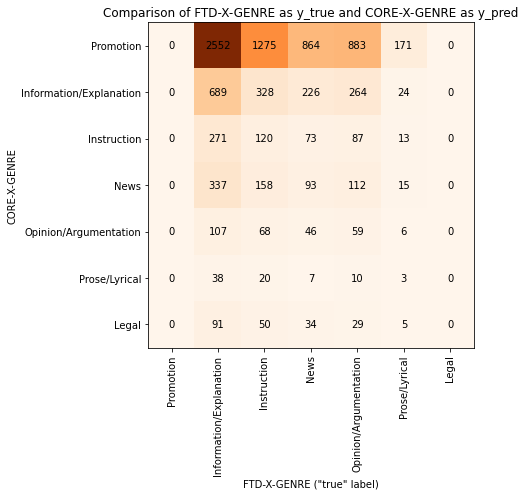

Comparison of classifiers: FTD-X-GENRE as y_true, X-GENRE as y_pred
Macro F1: 0.13, Micro F1: 0.3
                         precision    recall  f1-score   support

              Promotion       0.62      0.38      0.47      6282
Information/Explanation       0.16      0.17      0.17      1693
            Instruction       0.05      0.07      0.06       605
                   News       0.07      0.14      0.09       789
  Opinion/Argumentation       0.04      0.15      0.06       320
          Prose/Lyrical       0.00      0.00      0.00        84
                  Legal       0.03      0.02      0.03       227

              micro avg       0.31      0.29      0.30     10000
              macro avg       0.14      0.13      0.13     10000
           weighted avg       0.43      0.29      0.34     10000



<Figure size 432x288 with 0 Axes>

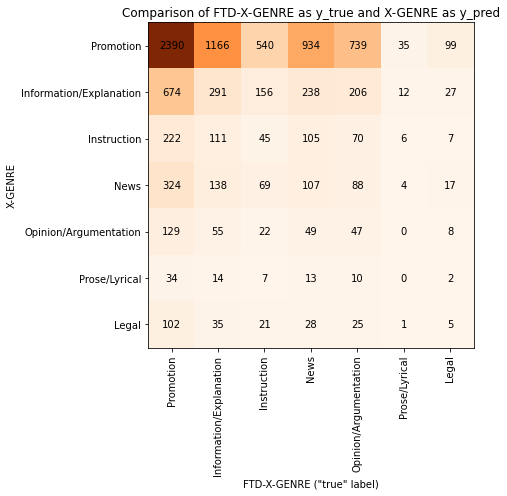

Comparison of classifiers: CORE-X-GENRE as y_true, GINCO-X-GENRE as y_pred
Macro F1: 0.08, Micro F1: 0.12


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

Information/Explanation       0.41      0.15      0.22      4085
            Instruction       0.22      0.09      0.13      2019
              Promotion       0.00      0.00      0.00         0
  Opinion/Argumentation       0.15      0.11      0.13      1444
                  Forum       0.09      0.03      0.04       698
                   News       0.13      0.14      0.14      1343
                  Other       0.02      0.07      0.03       174
                  Legal       0.00      0.00      0.00         0
          Prose/Lyrical       0.00      0.00      0.00       237

               accuracy                           0.12     10000
              macro avg       0.11      0.06      0.08     10000
           weighted avg       0.26      0.12      0.15     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

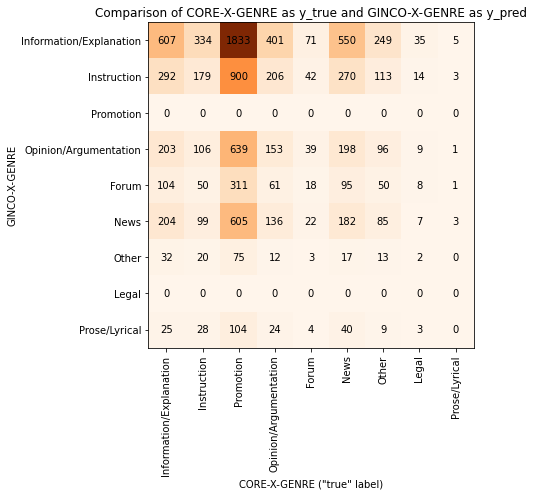

Comparison of classifiers: CORE-X-GENRE as y_true, FTD-X-GENRE as y_pred
Macro F1: 0.07, Micro F1: 0.1


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

              Promotion       0.00      0.00      0.00         0
Information/Explanation       0.41      0.17      0.24      4085
            Instruction       0.20      0.06      0.09      2019
                   News       0.12      0.07      0.09      1343
  Opinion/Argumentation       0.18      0.04      0.07      1444
          Prose/Lyrical       0.04      0.01      0.02       237
                  Legal       0.00      0.00      0.00         0

              micro avg       0.10      0.11      0.10      9128
              macro avg       0.13      0.05      0.07      9128
           weighted avg       0.27      0.11      0.15      9128



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

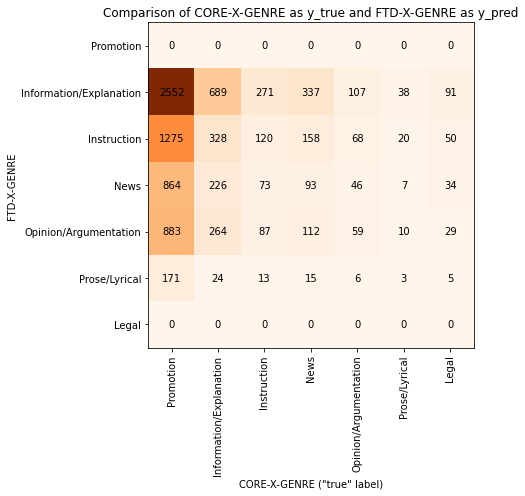

Comparison of classifiers: CORE-X-GENRE as y_true, X-GENRE as y_pred
Macro F1: 0.08, Micro F1: 0.13


/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/

                         precision    recall  f1-score   support

              Promotion       0.00      0.00      0.00         0
  Opinion/Argumentation       0.15      0.12      0.13      1444
                  Other       0.02      0.03      0.02       174
                   News       0.13      0.14      0.13      1343
Information/Explanation       0.41      0.18      0.25      4085
            Instruction       0.23      0.10      0.14      2019
                  Legal       0.00      0.00      0.00         0
                  Forum       0.07      0.02      0.03       698
          Prose/Lyrical       0.00      0.00      0.00       237

               accuracy                           0.13     10000
              macro avg       0.11      0.07      0.08     10000
           weighted avg       0.26      0.13      0.17     10000



/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

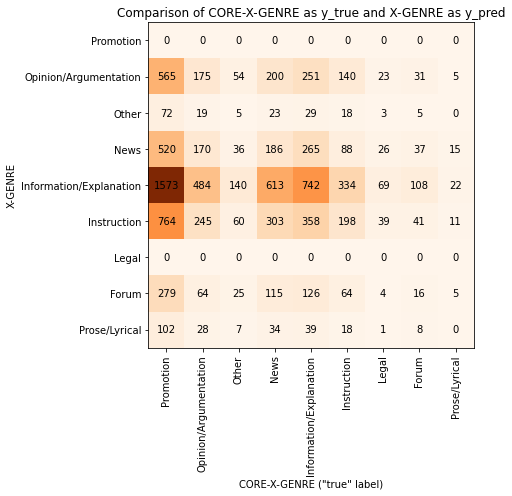

Comparison of classifiers: X-GENRE as y_true, GINCO-X-GENRE as y_pred
Macro F1: 0.11, Micro F1: 0.24
                         precision    recall  f1-score   support

Information/Explanation       0.18      0.15      0.16      1810
            Instruction       0.09      0.08      0.08       860
              Promotion       0.38      0.44      0.41      3875
  Opinion/Argumentation       0.12      0.10      0.11      1185
                  Forum       0.03      0.02      0.03       246
                   News       0.15      0.14      0.14      1474
                  Other       0.04      0.07      0.05       327
                  Legal       0.01      0.01      0.01       165
          Prose/Lyrical       0.00      0.00      0.00        58

               accuracy                           0.24     10000
              macro avg       0.11      0.11      0.11     10000
           weighted avg       0.23      0.24      0.23     10000



<Figure size 432x288 with 0 Axes>

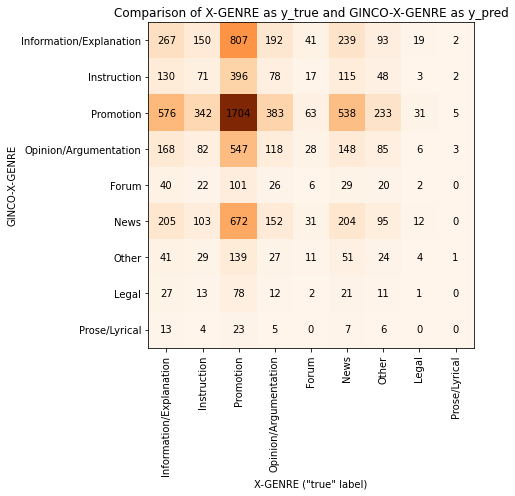

Comparison of classifiers: X-GENRE as y_true, FTD-X-GENRE as y_pred
Macro F1: 0.13, Micro F1: 0.3
                         precision    recall  f1-score   support

              Promotion       0.38      0.62      0.47      3875
Information/Explanation       0.17      0.16      0.17      1810
            Instruction       0.07      0.05      0.06       860
                   News       0.14      0.07      0.09      1474
  Opinion/Argumentation       0.15      0.04      0.06      1185
          Prose/Lyrical       0.00      0.00      0.00        58
                  Legal       0.02      0.03      0.03       165

              micro avg       0.29      0.31      0.30      9427
              macro avg       0.13      0.14      0.13      9427
           weighted avg       0.24      0.31      0.25      9427



<Figure size 432x288 with 0 Axes>

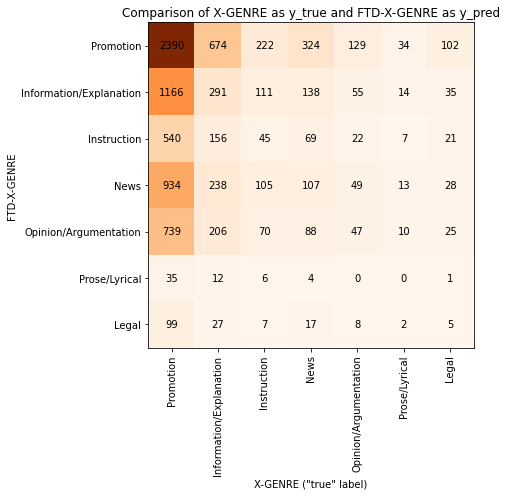

Comparison of classifiers: X-GENRE as y_true, CORE-X-GENRE as y_pred
Macro F1: 0.1, Micro F1: 0.17
                         precision    recall  f1-score   support

Information/Explanation       0.18      0.41      0.25      1810
  Opinion/Argumentation       0.12      0.15      0.13      1185
                   News       0.14      0.13      0.13      1474
          Prose/Lyrical       0.00      0.00      0.00        58
            Instruction       0.10      0.23      0.14       860
                  Forum       0.02      0.07      0.03       246
                  Other       0.03      0.02      0.02       327

              micro avg       0.13      0.22      0.17      5960
              macro avg       0.08      0.14      0.10      5960
           weighted avg       0.13      0.22      0.16      5960



<Figure size 432x288 with 0 Axes>

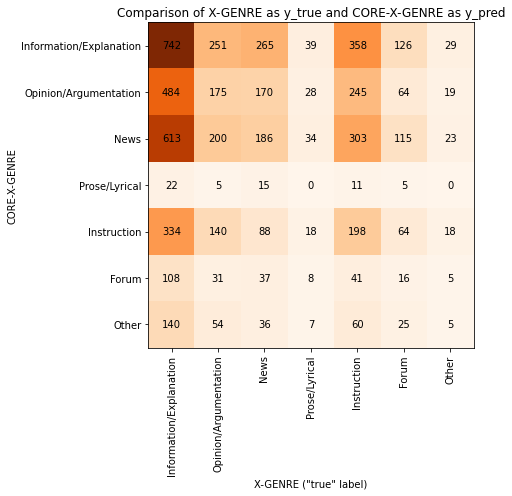

| Classifier as y_true   | Classifier as y_pred   |   Macro F1 |   Micro F1 |   Macro precision |   Macro recall |
|:-----------------------|:-----------------------|-----------:|-----------:|------------------:|---------------:|
| GINCO-X-GENRE          | FTD-X-GENRE            |       0.13 |       0.33 |              0.13 |           0.14 |
| FTD-X-GENRE            | GINCO-X-GENRE          |       0.13 |       0.33 |              0.14 |           0.13 |
| FTD-X-GENRE            | X-GENRE                |       0.13 |       0.3  |              0.14 |           0.13 |
| X-GENRE                | FTD-X-GENRE            |       0.13 |       0.3  |              0.13 |           0.14 |
| GINCO-X-GENRE          | X-GENRE                |       0.11 |       0.24 |              0.11 |           0.11 |
| X-GENRE                | GINCO-X-GENRE          |       0.11 |       0.24 |              0.11 |           0.11 |
| GINCO-X-GENRE          | CORE-X-GENRE           |       0.1  |       0.15 |   

<Figure size 432x288 with 0 Axes>

In [5]:
utils.x_genre_classifier_agreement(extended_corpus)

# Analysis of which labels often occur together

I had another idea that we could analyse which labels occur together using the apriori algorithm which is used in association rule learning.

Main concepts:

- Support: It measures the number of times a particular item or combination of items occur in a dataset out of the number of all instances.
`Support(pair) = frequency_of_pair/no_of_instances`

- Confidence: It measures how likely the pair will occur given they the left value has been predicted - number of times both have been predicted together divided by a number of time the left value has been predicted (-> if the left value occurs very often, the confidence will be smaller)
`Confidence(pair (based of occurrence of left value)) = frequency_of_pair/frequency of left value`

- Lift: A lift is a metric that determines the strength of association between the best rules. It is obtained by taking confidence (based on the frequency of the left value and right value) dand diving it with support (for right value). 
`Lift(pair (based on occurrence of left value)) = Confidence(based on occurrence of left value)/Support(right value)}`

This means that if left value is very frequent -> confidence is smaller, if the pair does not occur together very often, it won't reach the confidence limit. The frequency of right value does not impact the confidence, but it does impact the lift. For the same number of occurences of the pair, the lift is higher if one of them is infrequent than if both were frequent. The bigger support (frequency of the pair occuring together), the bigger is lift.

two most frequent values, always occurring together:
left = 7
right = 7

occur = 7/10
total = 10

confidence = 7/10 / 7/10 = 1

support = 7/10

lift = 1 / 0.7 = 1.42

-----------
two not so frequent values always occurring together:

left = 4
right = 4

occur = 4/10

confidence = 1

support = 0.4

lift = 1/0.4 = 2.5

In [11]:
utils.calculate_apriori(extended_corpus, classifiers)

/home/tajak/Genre-Datasets-Comparison/Genre-Datasets-Comparison/Comparison-on-MaCoCu-data/Comparison-on-MaCoCu-sl-sample2/utils.py:521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_small[i] = "{}: ".format(i) + corpus_small[i].astype(str)


Comparison: FTD with GINCO
| Left_Hand_Side         | Right_Hand_Side                |   Support |   Confidence |    Lift |
|:-----------------------|:-------------------------------|----------:|-------------:|--------:|
| FTD: A7 (instruction)  | GINCO: Instruction             |    0.0383 |     0.728137 | 9.76055 |
| FTD: A8 (news)         | GINCO: News/Reporting          |    0.0434 |     0.82197  | 6.83835 |
| FTD: A11 (personal)    | GINCO: Opinion/Argumentation   |    0.0224 |     0.724919 | 6.03094 |
| FTD: A16 (information) | GINCO: Information/Explanation |    0.0842 |     0.651199 | 4.56022 |
| FTD: A12 (promotion)   | GINCO: Promotion               |    0.3854 |     0.654218 | 1.61775 |
Labels not matched: ['FTD: A1 (argumentative)', 'FTD: A17 (review)', 'FTD: A9 (legal)', 'FTD: A4 (fiction)', 'FTD: A14 (academic)', 'GINCO: List of Summaries/Excerpts', 'GINCO: Other', 'GINCO: Legal/Regulation', 'GINCO: Forum']
Comparison: FTD with CORE
| Left_Hand_Side                        